<a href="https://colab.research.google.com/github/SKies2003/TimeSeries/blob/main/French_bakery_daily_sales_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# !pip install statsforecast utilsforecast

utilsforecast resource: https://nixtlaverse.nixtla.io/utilsforecast

statsforecast resorce: https://nixtlaverse.nixtla.io/statsforecast

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(r"/content/daily_sales_french_bakery.csv", parse_dates=["ds"])
print(df.head())
print(df.tail())

    unique_id         ds     y  unit_price
0  12 MACARON 2022-07-13  10.0        10.0
1  12 MACARON 2022-07-14   0.0        10.0
2  12 MACARON 2022-07-15   0.0        10.0
3  12 MACARON 2022-07-16  10.0        10.0
4  12 MACARON 2022-07-17  30.0        10.0
       unique_id         ds     y  unit_price
57041  VIK BREAD 2022-09-26   0.0         2.7
57042  VIK BREAD 2022-09-27   0.0         2.7
57043  VIK BREAD 2022-09-28   0.0         2.7
57044  VIK BREAD 2022-09-29   0.0         2.7
57045  VIK BREAD 2022-09-30  32.4         2.7


In [4]:
df = df.groupby("unique_id").filter(lambda x: len(x) >= 28)
df = df.drop(["unit_price"], axis = 1)
print(df.head())
print(df.tail())

    unique_id         ds     y
0  12 MACARON 2022-07-13  10.0
1  12 MACARON 2022-07-14   0.0
2  12 MACARON 2022-07-15   0.0
3  12 MACARON 2022-07-16  10.0
4  12 MACARON 2022-07-17  30.0
       unique_id         ds     y
57041  VIK BREAD 2022-09-26   0.0
57042  VIK BREAD 2022-09-27   0.0
57043  VIK BREAD 2022-09-28   0.0
57044  VIK BREAD 2022-09-29   0.0
57045  VIK BREAD 2022-09-30  32.4


In [17]:
print(df["unique_id"].unique())

['12 MACARON' 'BAGUETTE' 'BAGUETTE APERO' 'BAGUETTE GRAINE' 'BANETTE'
 'BANETTINE' 'BOISSON 33CL' 'BOULE 200G' 'BOULE 400G' 'BOULE POLKA'
 'BRIOCHE' 'BRIOCHETTE' 'BROWNIES' 'CAFE OU EAU' 'CAMPAGNE' 'CARAMEL NOIX'
 'CEREAL BAGUETTE' 'CHAUSSON AUX POMMES' 'CHOCOLAT' 'CHOU CHANTILLY'
 'COMPLET' 'COOKIE' 'COUPE' 'CROISSANT' 'CROISSANT AMANDES' 'CRUMBLE'
 'DELICETROPICAL' 'DEMI BAGUETTE' 'DEMI PAIN' 'DIVERS BOISSONS'
 'DIVERS BOULANGERIE' 'DIVERS CONFISERIE' 'DIVERS PATISSERIE'
 'DIVERS SANDWICHS' 'DIVERS VIENNOISERIE' 'ECLAIR'
 'ECLAIR FRAISE PISTACHE' 'FICELLE' 'FINANCIER' 'FINANCIER X5' 'FLAN'
 'FLAN ABRICOT' 'FONDANT CHOCOLAT' 'FORMULE PATE' 'FORMULE PLAT PREPARE'
 'FORMULE SANDWICH' 'FRAISIER' 'FRAMBOISIER' 'GACHE' 'GAL FRANGIPANE 4P'
 'GAL FRANGIPANE 6P' 'GAL POIRE CHOCO 4P' 'GAL POIRE CHOCO 6P'
 'GAL POMME 4P' 'GAL POMME 6P' 'GD FAR BRETON' 'GD KOUIGN AMANN'
 'GD NANTAIS' 'GRAND FAR BRETON' 'GRANDE SUCETTE' 'GUERANDAIS'
 'KOUIGN AMANN' 'MACARON' 'MERINGUE' 'MILLES FEUILLES' 'MOISSON'

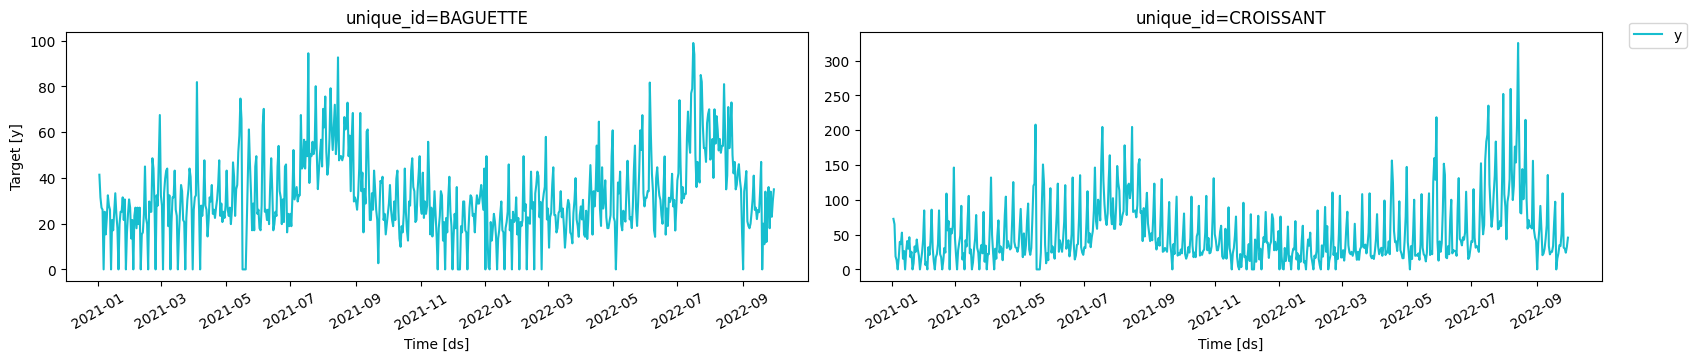

In [5]:
plot_series(
    df=df,
    ids=["BAGUETTE", "CROISSANT"]
)

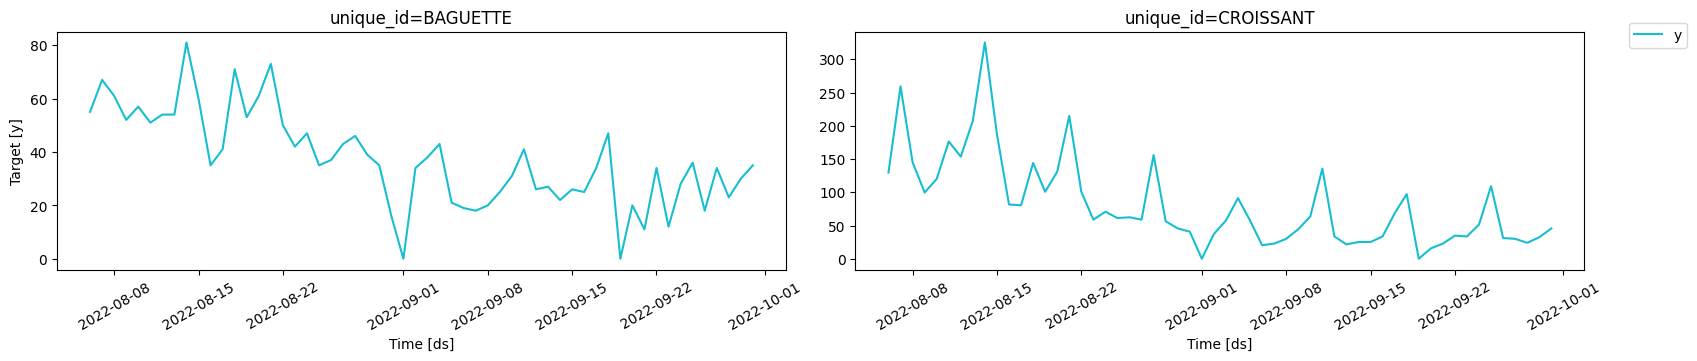

In [6]:
# Let's zoom-in to last 56 days
plot_series(
    df=df,
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=56
)

In [7]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, SeasonalNaive, WindowAverage

In [8]:
models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=df)
preds = sf.predict(h=7) # h stands for horizon

In [9]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


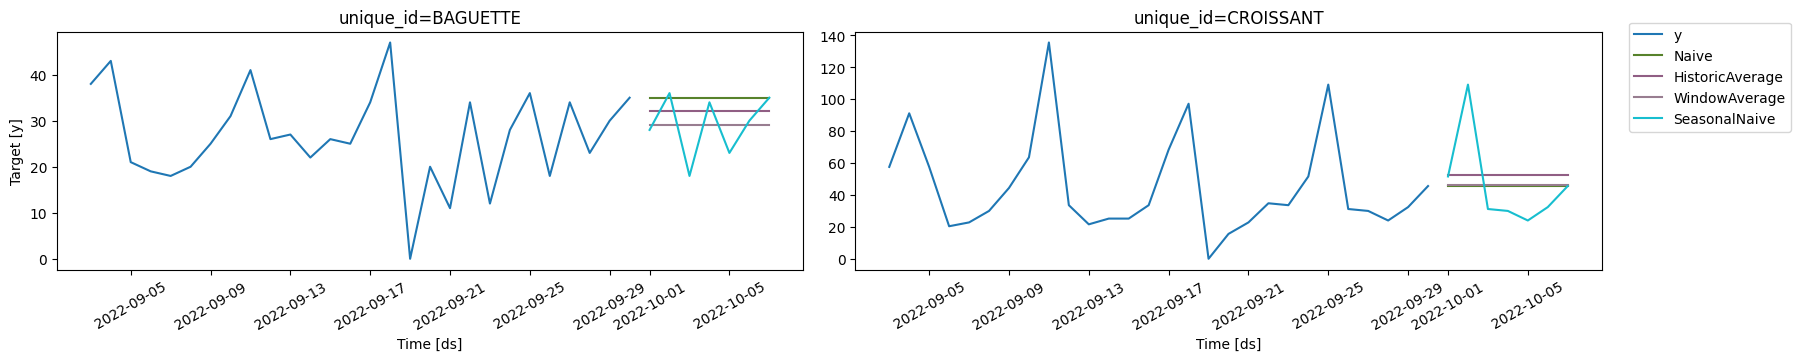

In [10]:
plot_series(
    df=df,
    forecasts_df = preds,
    ids = ["BAGUETTE", "CROISSANT"],
    max_insample_length = 28
)

In [11]:
# Train test split manually by numbers
test = df.groupby("unique_id").tail(7)
train = df.drop(test.index).reset_index(drop=True)

In [18]:
sf.fit(df=train)
preds = sf.predict(h=7)
eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id'])

In [20]:
evaluation = evaluate(
    eval_df,
    metrics = [mae] # mae stands for Mean Absolute Error
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [21]:
evaluation = evaluation.drop(["unique_id"], axis = 1).groupby("metric").mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636
